## **Assignment 2 - Image segmentation : Seahorse Dataset**
**Neptun code:**  QNGHMC

**Name:** Donia Gharbi

##Imports


In [59]:
import torch
from PIL import Image
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
import json

import numpy as np
import PIL.Image
import cv2

import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
import warnings
warnings.filterwarnings('ignore')

from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Download dataset


In [60]:
if os.path.isdir('seahorsedataset')==False:
    gdd.download_file_from_google_drive(file_id='1donm2J-Hl92nRSG00xmJxU5IZa2RdJxT',
                                    dest_path='./seahorsedataset.zip',
                                    unzip=True)

## Generate masks


In [61]:
if os.path.isdir('binary_masks')==False:
  os.makedirs("binary_masks")

with open("annotations.json", "r") as read_file:
    data = json.load(read_file)
all_file_names=list(data.keys())
all_file_names.sort()
Files_in_directory = []
for root, dirs, files in os.walk("images"):
    for filename in files:
        Files_in_directory.append(filename)  

for j in range(len(all_file_names)):
  
    image_name=data[all_file_names[j]]['filename']
    if image_name in Files_in_directory: 
         img = np.asarray(PIL.Image.open('images/'+image_name))    
    else:
        continue

    if data[all_file_names[j]]['regions'] != {}:
        try: 
             shape1_x=data[all_file_names[j]]['regions']['0']['shape_attributes']['all_points_x']
             shape1_y=data[all_file_names[j]]['regions']['0']['shape_attributes']['all_points_y']
        except : 
             shape1_x=data[all_file_names[j]]['regions'][0]['shape_attributes']['all_points_x']
             shape1_y=data[all_file_names[j]]['regions'][0]['shape_attributes']['all_points_y']

        ab=np.stack((shape1_x, shape1_y), axis=1)
        img2=cv2.drawContours(img, [ab], -1, (255,255,255), -1)
        mask = np.zeros((img.shape[0],img.shape[1]))
        img3=cv2.drawContours(mask, [ab], -1, 255, -1)
        cv2.imwrite('binary_masks/%05.0f' % j +'.png',mask.astype(np.uint8))

## Example from dataset

###Image

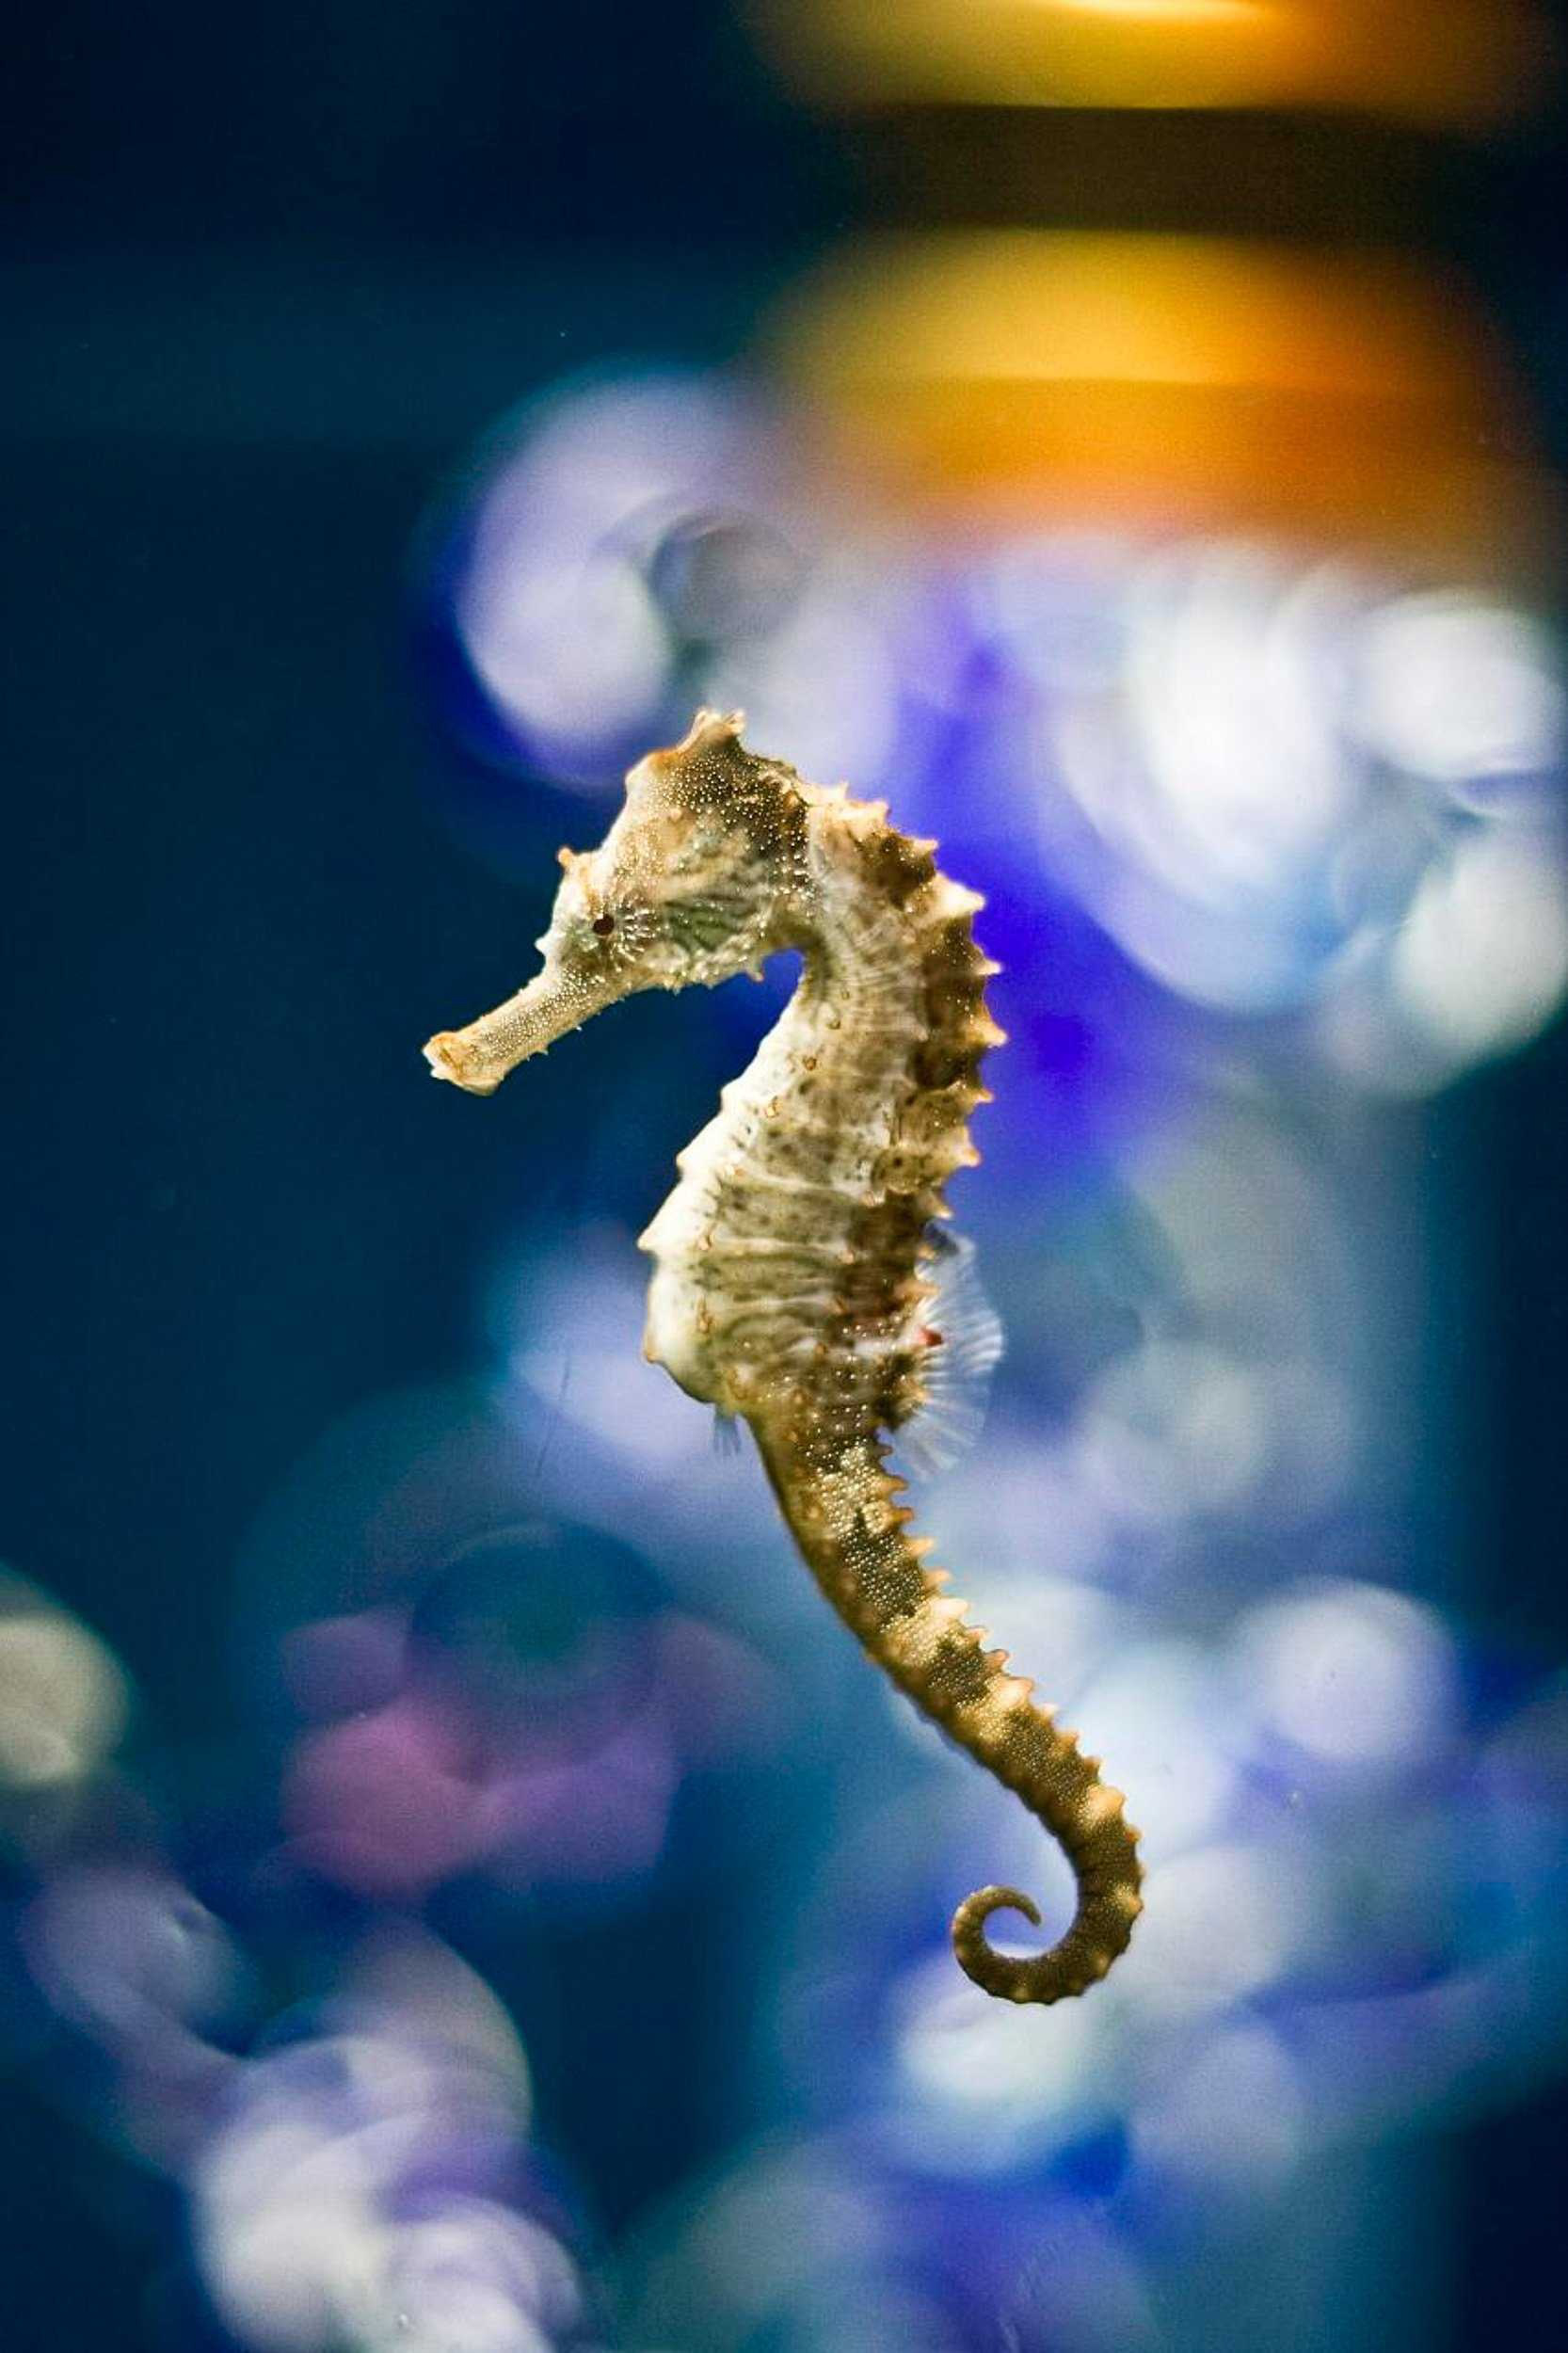

In [62]:
img = Image.open('images/42XV1B3A6J1V.jpg')
img

###Mask

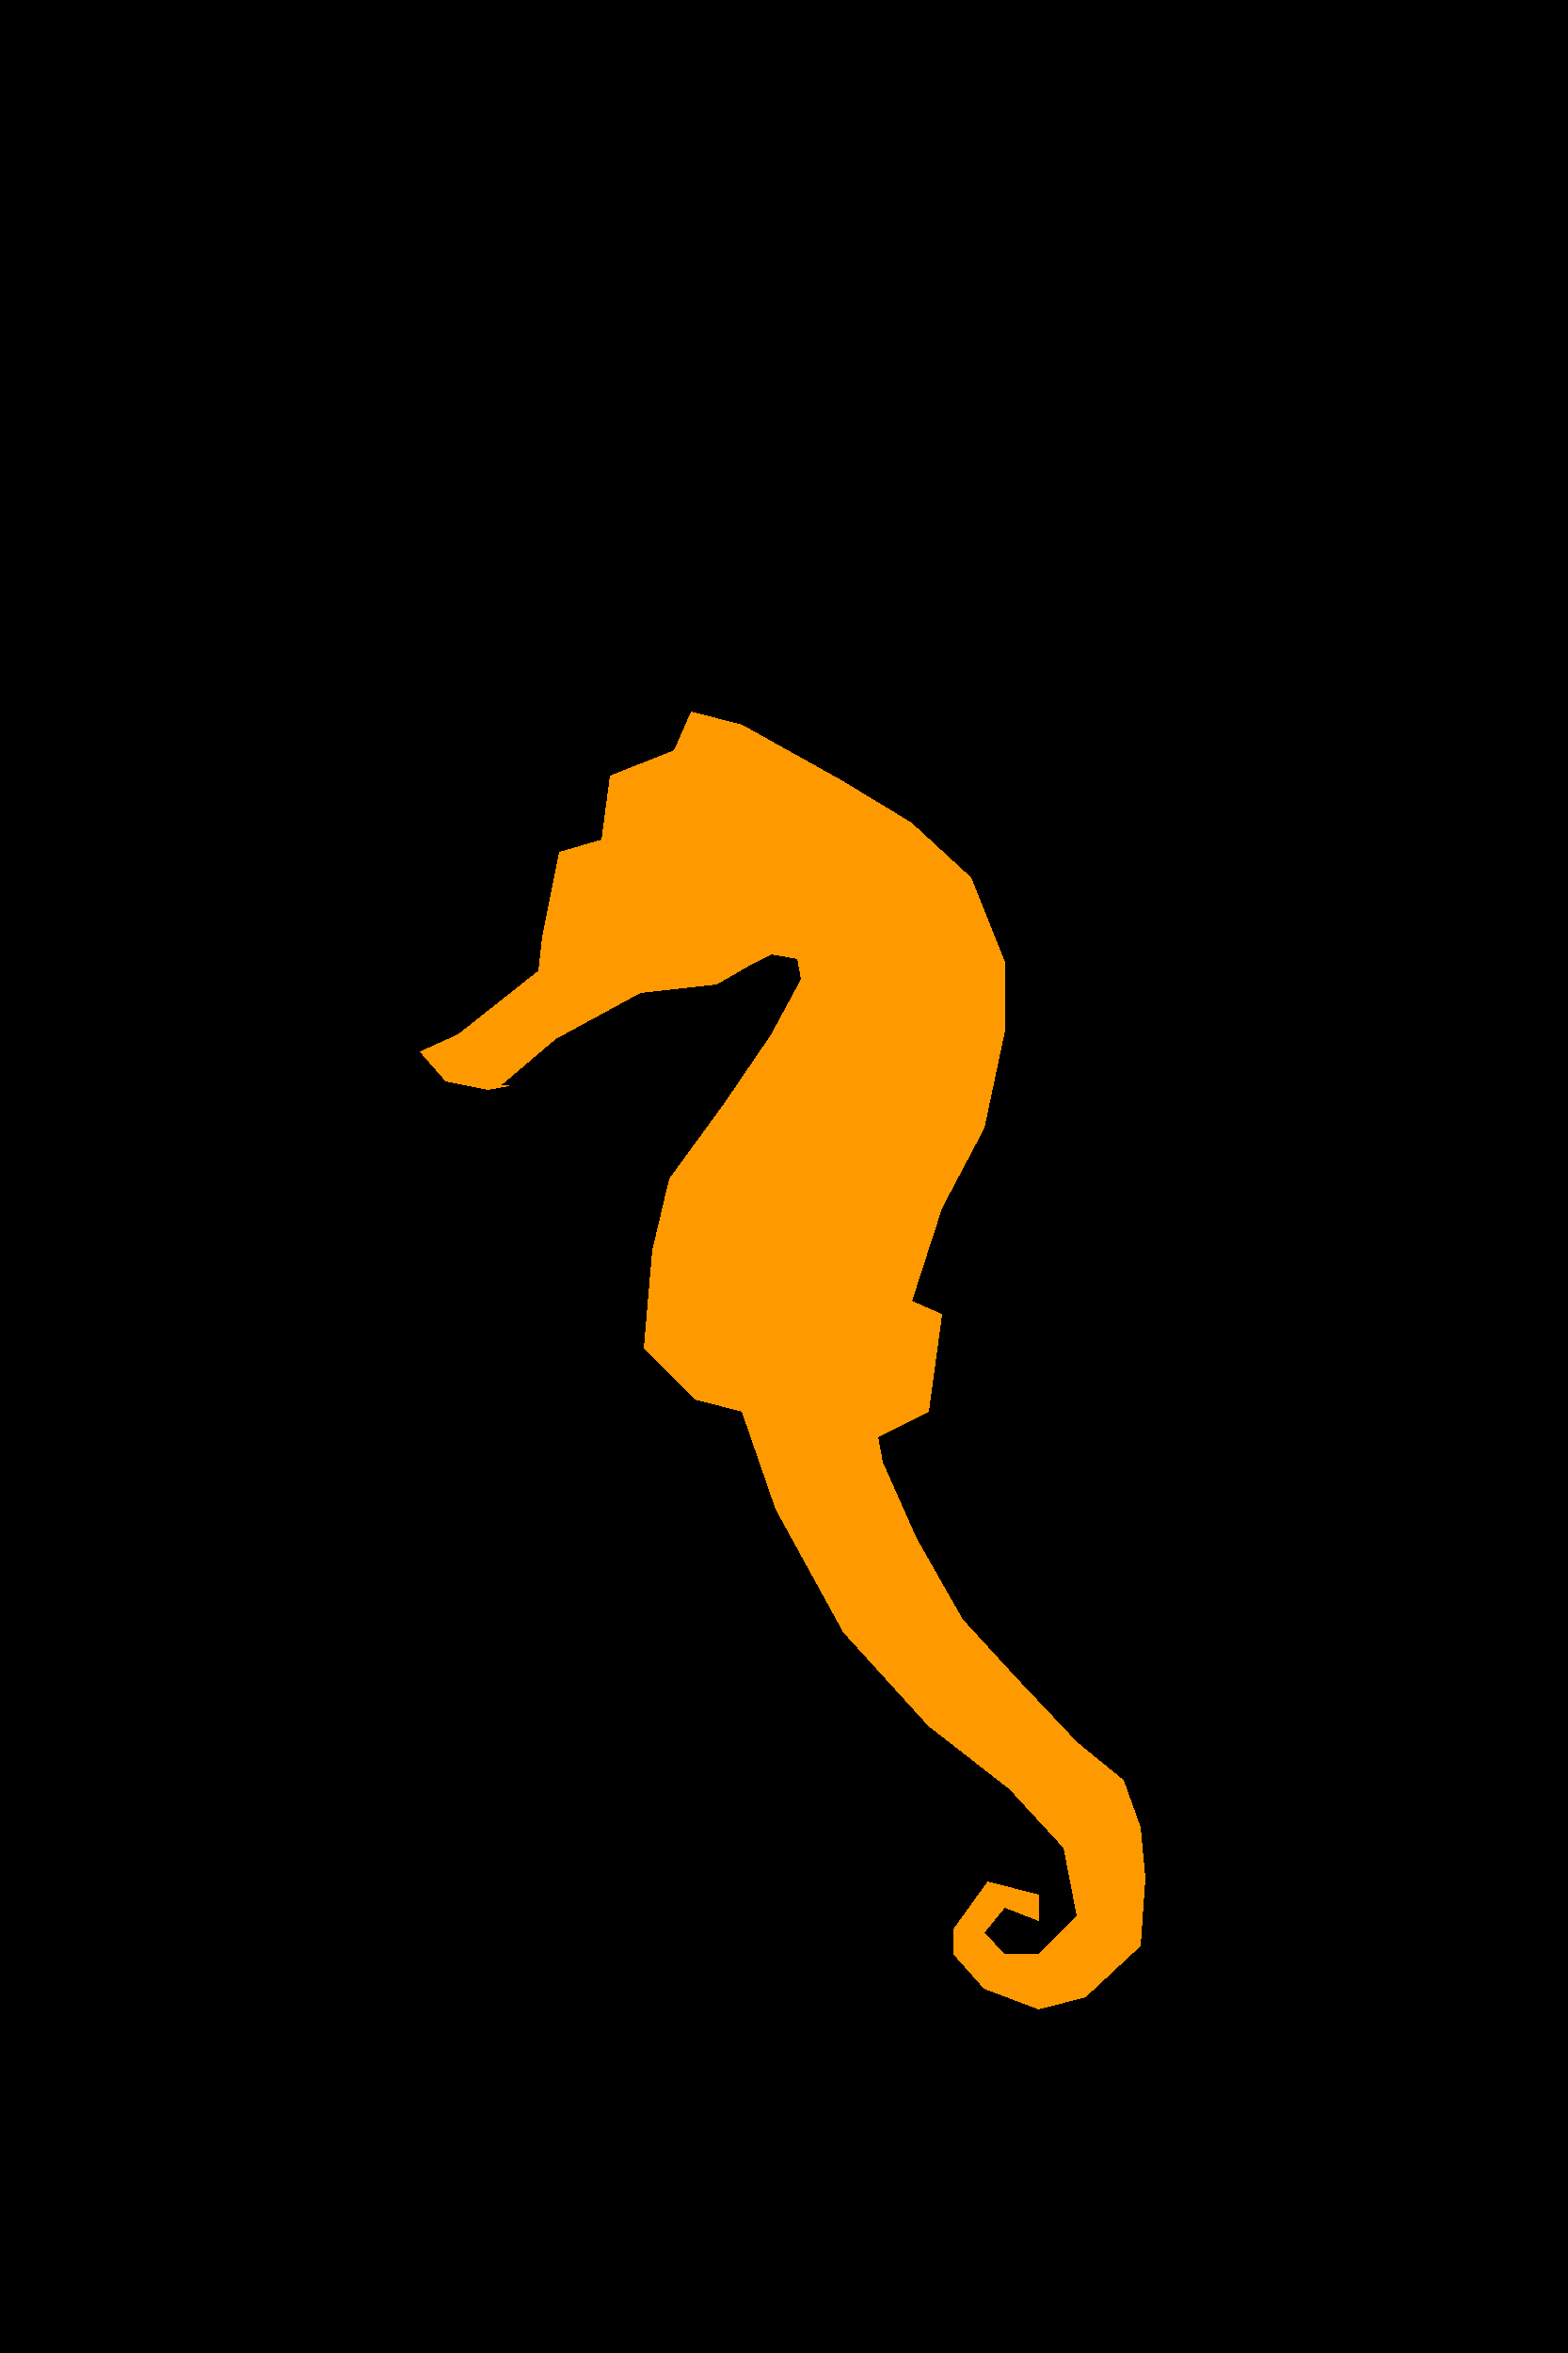

In [63]:
mask = Image.open('binary_masks/00002.png').convert("L")
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

##Model developement

In [64]:
class SeahorseDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "binary_masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "binary_masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes # the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
        target["labels"] = labels # the label for each bounding box
        target["masks"] = masks # The segmentation masks for each one of the objects
        target["image_id"] = image_id # an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
        target["area"] = area # The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
        target["iscrowd"] = iscrowd #  instances with iscrowd=True will be ignored during evaluation.

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [65]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [66]:
if os.path.isdir('vision')==False:
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.8.2
    !cp references/detection/utils.py ../
    !cp references/detection/transforms.py ../
    !cp references/detection/coco_eval.py ../
    !cp references/detection/engine.py ../
    !cp references/detection/coco_utils.py ../
    %cd ../
    cwd = os.getcwd()
    print(cwd)

In [67]:


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = SeahorseDataset('./', get_transform(train=True))
dataset_test = SeahorseDataset('./', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [68]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

# our dataset has two classes only - background and seahorse
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device: cuda:0


In [69]:
# number of epochs
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:00:12  lr: 0.000268  loss: 3.8222 (3.8222)  loss_classifier: 0.4032 (0.4032)  loss_box_reg: 0.1499 (0.1499)  loss_mask: 3.2562 (3.2562)  loss_objectness: 0.0085 (0.0085)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.6484  data: 0.0820  max mem: 9110
Epoch: [0]  [10/20]  eta: 0:00:07  lr: 0.002897  loss: 1.6047 (1.9089)  loss_classifier: 0.1840 (0.2055)  loss_box_reg: 0.1140 (0.1063)  loss_mask: 1.3437 (1.5593)  loss_objectness: 0.0225 (0.0237)  loss_rpn_box_reg: 0.0084 (0.0141)  time: 0.7619  data: 0.0814  max mem: 9386
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 1.0444 (1.4202)  loss_classifier: 0.0778 (0.1450)  loss_box_reg: 0.0987 (0.0986)  loss_mask: 0.8349 (1.1419)  loss_objectness: 0.0209 (0.0213)  loss_rpn_box_reg: 0.0060 (0.0134)  time: 0.7280  data: 0.0765  max mem: 9386
Epoch: [0] Total time: 0:00:14 (0.7282 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:01  model_time: 0.1365 (0.1365)  evaluator_time: 0.0075 (0.0075)  

In [70]:
if os.path.isdir('maskrcnn_weights')==False: os.mkdir('maskrcnn_weights') 

In [71]:
torch.save(model, 'maskrcnn_weights/mask-rcnn-seahorse.pt')

In [72]:
torch.save(model.state_dict(), 'maskrcnn_weights/mask-rcnn-seahorse_weights.pt') 

In [73]:
model.load_state_dict(torch.load(os.getcwd()+'/maskrcnn_weights/mask-rcnn-seahorse_weights.pt'))

<All keys matched successfully>

In [74]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'seahorse']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
      #cv2.rectangle and cv2.putText version dependent
      pt1 = tuple([int(j) for j in boxes[i][0]])
      pt2 = tuple([int(j) for j in boxes[i][1]])  
      cv2.rectangle(img, pt1, pt2,color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(10,15))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

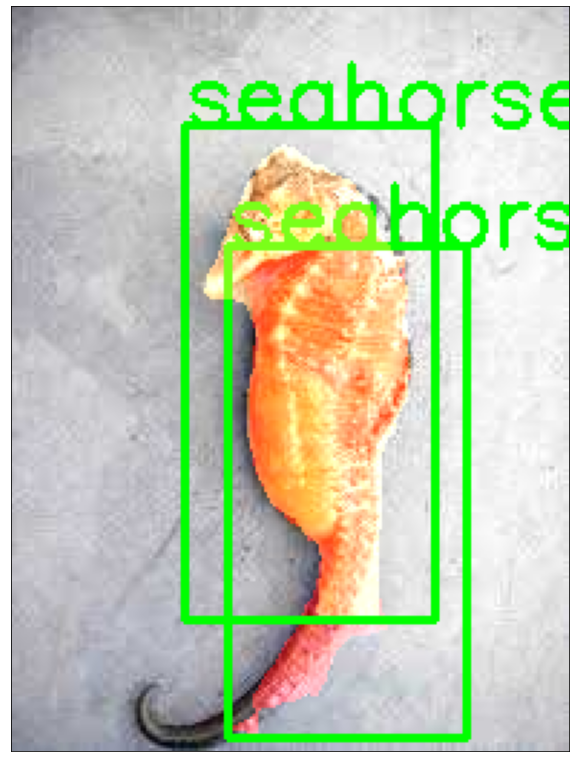

In [84]:
segment_instance('test/94AOJTIX2VSY.jpg', confidence=0.4)

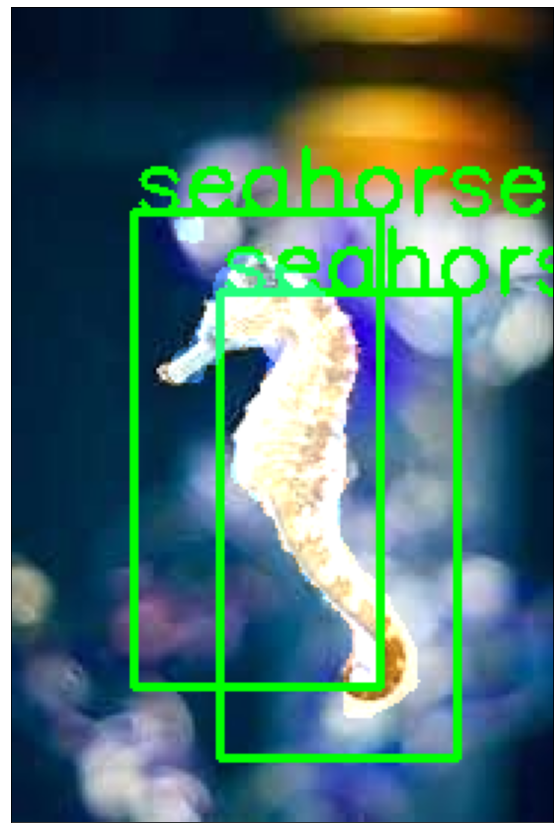

In [85]:
segment_instance('test/5AJCS85MOQ73.jpg', confidence=0.4)

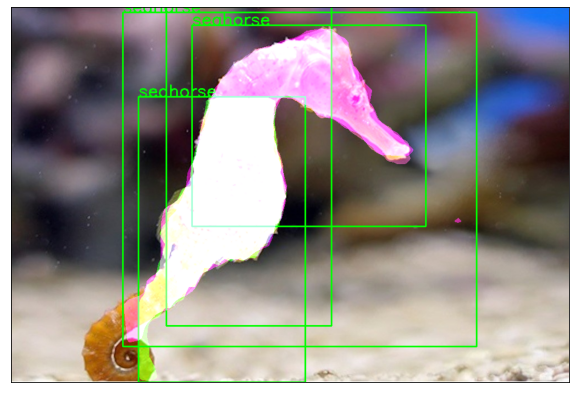

In [86]:
segment_instance('test/seahorse-2-2297-xl.jpg', confidence=0.4)

## About assignement:
**Object:** Seahorse

**Dataset:** size : 50 images

I tried to use masks generated by the tool provided in the task descrption : Computer Vision Annotation Tool (cvat). but I got the following error: *zero-size array to reduction operation minimum which has no identity*. So I generated the masks instead using a Json annotations generated by the tool VGG Image Annotator (via) and this model to generate masks: https://github.com/maftouni/binary_mask_from_json


The accuracy could be improved if the Dataset was bigger. 
